## import

In [1]:
import json, os, math, sys, glob
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
sys.path.append('./opmap/')
from opmap.phaseMap import PhaseMap
from opmap.phaseVarianceMap import PhaseVarianceMap
from opmap.PhaseVariancePeakMap import PhaseVariancePeakMap

In [85]:
from util_ana import set_col_extra

## Functions

In [3]:
def normalize(im):
    return (im - im.min())/max(im.max()-im.min(), 1.0e-10)

def CenterOfGravity(mat):
    hei,wid = mat.shape
    Tile=np.arange(wid,dtype=float)-(wid-1.0)/2.0
    Tx = np.tile(Tile,[hei,1])
    Sum = np.sum(mat)
    Ax = np.sum(mat*Tx)/Sum
    Ay = np.sum(mat*Tx.T)/Sum
    return math.atan2(Ay, Ax), np.linalg.norm(np.array([Ay, Ax]))

In [4]:
def analyze_non_passive(ps):
    flag_np = (np.sum(np.sum(ps.data, axis=1), axis=1)>0)*1
    rate_np = np.sum(flag_np)/float(len(flag_np))
    return flag_np, rate_np

In [5]:
def draw(pmap_path, ps):
    
    files = sorted(glob.glob(os.path.join(pmap_path,"00*.png")))
    
    save_path = pmap_path.rstrip('/')+'_ps'    
    if not os.path.exists(save_path): os.makedirs(save_path)
        
    for i, path in enumerate(files):
        img = cv2.imread(path)
        if i >= len(ps.data) : break
        img[ps.data[i,:] > 0] = [255,255,255]
        cv2.imwrite(os.path.join(save_path,"{0:0>6}.png".format(i)),img)
        
    return save_path

In [6]:
def saveMovie(dir_path):
    m_rate = 20
    cmd = 'ffmpeg -r {0} -y -i "{1}/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{1}.mp4"'.format(m_rate, dir_path.rstrip('/'))
    os.system(cmd)

In [7]:
def phaseComplement(value):
    value -= (value > np.pi)*2*np.pi
    value += (value < - np.pi)*2*np.pi
    return value

In [8]:
def rate_non_passive(ps):
    flg = (np.sum(np.sum(ps.data, axis=1), axis=1)>0)*1
    rate = np.sum(flg) / float(len(flg))
    return flg, rate

In [9]:
def saveMovie(dir_path):
    m_rate = 20
    cmd = 'ffmpeg -r {0} -y -i "{1}/%06d.png" -c:v libx264 -pix_fmt yuv420p -qscale 0 "{1}.mp4"'.format(m_rate, dir_path.rstrip('/'))
    os.system(cmd)

## Parameters

In [104]:
out_date = '20190828'
opath = "/mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/"
start = 100
end = 2000

In [11]:
ana_list = pd.read_csv("./session_all.csv")
ana_list

,﻿id,sample,session,elec_pattern,extra_dir,extra_sess,extra_delay
0,5,20180425-1,5,0,20180425,e002_04251532,0
1,9,20180425-1,9,0,20180425,e006_04251612,0
2,21,20180426-1,6,1,20180426,e001_04261048,0
3,25,20180426-1,10,3,20180426,e004_04261058,136
4,28,20180426-1,13,4,20180426,e007_04261105,0
5,50,20180612-1,6,6,20180612,e001_06121525,136
6,52,20180612-1,8,7,20180612,e003_06121541,0
7,54,20180612-1,10,8,20180612,e005_06121551,136
8,57,20180612-1,13,9,20180612,e008_06121610,0
9,64,20180614-1,5,10,20180614,e001_06141447,0


In [12]:
thre_np = 0.5

## Main

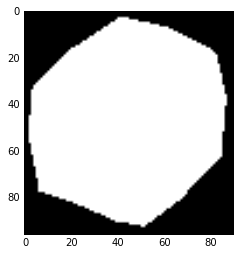

In [13]:
roi_extra = np.load("./roi_extra.npy")
plt.imshow(roi_extra, cmap='gray')

In [74]:
n_pixels = np.sum((roi_extra>0.0)*1)
n_pixels

5718

In [139]:
rate_ex = []
rate_op = []
list_pos_op = []
list_pos_ex = []
grad_angle ={'ex':[],'op':[]}
grad_norm ={'ex':[],'op':[]}

#plt.imshow(mask_t, cmap='gray')
cmap_extra = set_col_extra()

for i, ana_data in (ana_list.iterrows()):
    
    session = "{0}/C001H001S{1:0>4}".format(ana_data["sample"],ana_data["session"])
    save_path = os.path.join(os.path.join(opath,out_date), session)    
    print(i, save_path)
    
    pmap_ex = PhaseMap.load(os.path.join(save_path, 'pmap_ex.npy'))
    pmap_op = PhaseMap.load(os.path.join(save_path, 'pmap_op_on_ex.npy'))    
    pmap_ex.roi = roi_extra
    pmap_op.roi = roi_extra
    
    pv_ex = PhaseVarianceMap(pmap_ex, size=3)
    pv_op = PhaseVarianceMap(pmap_op, size=3)
        
    ps_ex = PhaseVariancePeakMap(pv_ex)
    ps_op = PhaseVariancePeakMap(pv_op)
    
    if False:
        path = draw(os.path.join(save_path, 'pmap_ex_mask'), ps_ex)
        saveMovie(path)
        path = draw(os.path.join(save_path, 'pmap_op_on_ex_mask'), ps_op)
        saveMovie(path)
        
    f_ex, r_ex = rate_non_passive(ps_ex)
    f_op, r_op = rate_non_passive(ps_op)
    rate_ex.append(r_ex)
    rate_op.append(r_op)
    
    print(r_ex, r_op)
    if r_op >= thre_np and r_ex >= thre_np:
    
        sps_ex = np.mean(ps_ex.data[20:-20],axis=0)
        sps_op = np.mean(ps_op.data[20:-20],axis=0)

        pos_ex = scipy.ndimage.measurements.center_of_mass(sps_ex)
        pos_op = scipy.ndimage.measurements.center_of_mass(sps_op)
        
        list_pos_op.append(pos_op)
        list_pos_ex.append(pos_ex)
        
        if False:
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            #plt.imshow(sps_op, cmap='jet')
            plt.imshow(np.sum(ps_op.data[20:-20],axis=0), cmap=plt.cm.gray_r)
            plt.colorbar()
            plt.scatter([pos_op[1]], [pos_op[0]], c='w')
            plt.title('op')
            plt.subplot(122)
            #plt.imshow(sps_ex, cmap='jet')
            plt.imshow(np.sum(ps_ex.data[20:-20],axis=0), cmap=plt.cm.gray_r)
            plt.colorbar()
            plt.scatter([pos_ex[1]], [pos_ex[0]], c='w')
            plt.title('ex')
            plt.savefig(os.path.join(save_path, 'compare_sps.png'))
            plt.show()
        
    elif r_op < thre_np and r_ex < thre_np:
        ## phase gradient
        pmaps = {'ex':pmap_ex,'op':pmap_op}
        for key in pmaps.keys():
            
            pmap = pmaps[key]            
            pmap.data *= roi_extra
            pmap.cmap = set_col_extra()
            
            path = os.path.join(save_path, 'pmap_{0}_grad'.format(key))
            if not os.path.exists(path): os.mkdir(path)
                
            L, H, W = pmap.data.shape
            sum_s = 0.
            sum_c = 0.
            
            x = np.arange(W)
            y = np.arange(H)
            X,Y = np.meshgrid(x, y)
            
            for f in range(len(pmap.data)):

                grad_y, grad_x = np.gradient(pmap.data[f,:], .5, .5)
                grad_x = phaseComplement(grad_x)
                grad_y = phaseComplement(grad_y)
                grad_x *= ps_ex.roi
                grad_y *= ps_ex.roi

                s = np.sum(np.sum(grad_y))
                c = np.sum(np.sum(grad_x))
                sum_s += s
                sum_c += c

                if True:
                    #pmap.showFrame(f)
                    plt.axes().set_aspect('equal')
                    cont = plt.contour(X,Y,pmap.data[f,:], cmap=cmap_extra)
                    plt.quiver(
                       [W//2], [H//2], [c], [s],
                       angles="xy", scale_units='xy',scale=10)
                    plt.savefig('{0}/{1:0>6}.png'.format(path, f))
                    plt.close()

            grad_angle[key].append( np.math.atan2(sum_s, sum_c)  )
            grad_norm[key].append( np.linalg.norm([sum_s,sum_c]) / (L*n_pixels)) 
            
            if False: saveMovie(path)


0 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180425-1/C001H001S0005
0.0 0.012
1 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180425-1/C001H001S0009
0.29 0.01
2 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180426-1/C001H001S0006
0.0 0.03
3 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180426-1/C001H001S0010
0.776381909548 0.820224719101
4 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180426-1/C001H001S0013
0.184 0.002
5 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180612-1/C001H001S0006
0.236180904523 0.00561797752809
6 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180612-1/C001H001S0008
0.66 0.266
7 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180612-1/C001H001S0010
0.0251256281407 0.217228464419
8 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180612-1/C001H001S0013
0.0 0.012
9 /mnt/Omer/Project/04.ExTRaMapping/AnalysisResult/20190828/20180614-1/C001H001S

## 興奮様態の分類

In [55]:
rate_op = np.array(rate_op)
rate_ex = np.array(rate_ex)

In [56]:
np.corrcoef(rate_op, rate_ex)

array([[ 1.        ,  0.95473728],
       [ 0.95473728,  1.        ]])

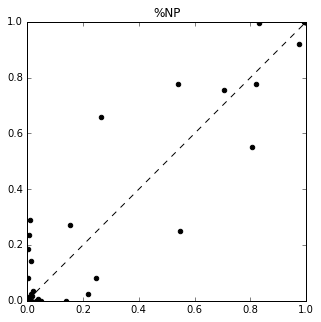

In [57]:
plt.figure(figsize=(5,5))
g = plt.subplot()
g.scatter(rate_op, rate_ex, c='k')
g.set_xlim([0.0, 1.0])
g.set_ylim([0.0, 1.0])
g.plot([0.0, 1.0],[0.0, 1.0], c='k', linestyle='dashed')
g.set_aspect('equal')
plt.title('%NP')

plt.savefig(os.path.join(os.path.join(opath,out_date), 'corr_npr.png'))


In [58]:
thre = 0.5

In [59]:
TP = np.where(( (rate_op>=thre) * (rate_ex>=thre))==True)[0]
FP = np.where(( (rate_op< thre) * (rate_ex>=thre))==True)[0]
TN = np.where(( (rate_op< thre) * (rate_ex< thre))==True)[0]
FN = np.where(( (rate_op>=thre) * (rate_ex< thre))==True)[0]

In [60]:
TP,FP,TN,FN

(array([ 3, 17, 18, 20, 22, 23, 24, 25, 31, 32, 34, 36, 37, 38, 39]),
 array([6]),
 array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 19, 26,
        27, 28, 29, 30, 33, 35, 40, 41]),
 array([21]))

In [87]:
print('sensitivity')
print(len(TP)/(len(TP)+len(FN)))

sensitivity
0.9375


In [88]:
print('specificity')
print(len(TP)/(len(TP)+len(FP)))

specificity
0.9375


## Non-Passiveの旋回中心位置の相関性

In [76]:
L, H, W = pmap_ex.data.shape
H, W

(96, 90)

In [77]:
arr_op = np.array(list_pos_op)
arr_ex = np.array(list_pos_ex)

x_op = arr_op[:,1] - W//2
y_op = arr_op[:,0] - H//2
x_ex = arr_ex[:,1] - W//2
y_ex = arr_ex[:,0] - H//2

norm_op = np.linalg.norm(np.array([x_op, y_op]), axis=0)
norm_ex = np.linalg.norm(np.array([x_ex, y_ex]), axis=0)

theta_op = np.array( [ np.math.atan2(y,x) for y, x in zip(y_op, x_op)])
theta_ex = np.array( [ np.math.atan2(y,x) for y, x in zip(y_ex, x_ex)])

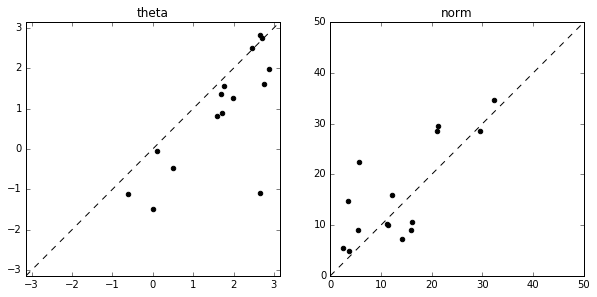

In [78]:
plt.figure(figsize=(10,10))

g=plt.subplot(121)
g.scatter(theta_op, theta_ex, c='k')
g.set_xlim([-np.pi, np.pi])
g.set_ylim([-np.pi, np.pi])
g.plot([-np.pi, np.pi], [-np.pi, np.pi], c='k', linestyle='dashed')
g.set_aspect('equal')
plt.title('theta')

g=plt.subplot(122)
g.scatter(norm_op, norm_ex, c='k')
g.set_xlim([0, 50])
g.set_ylim([0, 50])
g.plot([0, 50],[0, 50], c='k', linestyle='dashed')
g.set_aspect('equal')
plt.title('norm')

plt.savefig(os.path.join(os.path.join(opath,out_date), 'corr_pos.png'))


In [64]:
np.corrcoef(theta_op, theta_ex)

array([[ 1.        ,  0.74483339],
       [ 0.74483339,  1.        ]])

In [65]:
np.corrcoef(norm_op, norm_ex)

array([[ 1.        ,  0.76112234],
       [ 0.76112234,  1.        ]])

In [66]:
np.mean(np.linalg.norm(arr_op - arr_ex, axis=1))

11.346340277202186

## Passiveの興奮伝播方向の相関

In [79]:
for i, (op, ex) in enumerate(zip(grad_angle['op'], grad_angle['ex'])):
    if abs(ex-op) > np.pi:
        if ex > op: ex -= 2*np.pi
        else: ex += 2*np.pi
        print ('{0},{1}'.format(op, ex))
        grad_angle['ex'][i] = ex
        

-2.7308427154264887,-3.5262443648696236


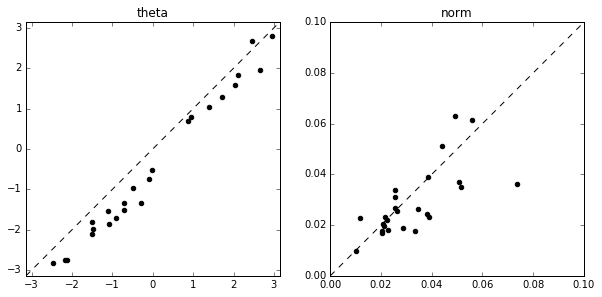

In [82]:
plt.figure(figsize=(10,10))

g=plt.subplot(121)
g.scatter(grad_angle['op'], grad_angle['ex'], c='k')
g.set_xlim([-np.pi, np.pi])
g.set_ylim([-np.pi, np.pi])
g.plot([-np.pi, np.pi], [-np.pi, np.pi], c='k', linestyle='dashed')
g.set_aspect('equal')
plt.title('theta')

g=plt.subplot(122)
g.scatter(grad_norm['op'], grad_norm['ex'], c='k')
g.set_xlim([0, 0.1])
g.set_ylim([0, 0.1])
g.plot([0, 0.1],[0, 0.1], c='k', linestyle='dashed')
g.set_aspect('equal')
plt.title('norm')

plt.savefig(os.path.join(os.path.join(opath,out_date), 'passive_grad.png'))

In [69]:
np.corrcoef(grad_angle['op'], grad_angle['ex'])

array([[ 1.        ,  0.99187192],
       [ 0.99187192,  1.        ]])

In [70]:
np.corrcoef(grad_norm['op'], grad_norm['ex'])

array([[ 1.        ,  0.70478542],
       [ 0.70478542,  1.        ]])

In [71]:
len(grad_angle['op'])

25

In [102]:
mask_roi = np.copy(roi_extra)
mask_roi[(mask_roi != 0)] = np.nan

In [105]:
plt.imsave(
    os.path.join(os.path.join(opath, out_date), 'mask_roi.png'), 
    mask_roi, cmap = "gray", vmax= 1,vmin=0)